![image info](https://raw.githubusercontent.com/albahnsen/MIAD_ML_and_NLP/main/images/banner_1.png)

# Proyecto 1 - Predicción de precios de vehículos usados

En este proyecto podrán poner en práctica sus conocimientos sobre modelos predictivos basados en árboles y ensambles, y sobre la disponibilización de modelos. Para su desasrrollo tengan en cuenta las instrucciones dadas en la "Guía del proyecto 1: Predicción de precios de vehículos usados".

**Entrega**: La entrega del proyecto deberán realizarla durante la semana 4. Sin embargo, es importante que avancen en la semana 3 en el modelado del problema y en parte del informe, tal y como se les indicó en la guía.

Para hacer la entrega, deberán adjuntar el informe autocontenido en PDF a la actividad de entrega del proyecto que encontrarán en la semana 4, y subir el archivo de predicciones a la [competencia de Kaggle](https://www.kaggle.com/t/4bd64c1deb3c4ffb8ca7ff93c1f1497d).

## Datos para la predicción de precios de vehículos usados

En este proyecto se usará el conjunto de datos de Car Listings de Kaggle, donde cada observación representa el precio de un automóvil teniendo en cuenta distintas variables como: año, marca, modelo, entre otras. El objetivo es predecir el precio del automóvil. Para más detalles puede visitar el siguiente enlace: [datos](https://www.kaggle.com/jpayne/852k-used-car-listings).

## Ejemplo predicción conjunto de test para envío a Kaggle

En esta sección encontrarán el formato en el que deben guardar los resultados de la predicción para que puedan subirlos a la competencia en Kaggle.

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Importación librerías
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import category_encoders as ce
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_percentage_error
import category_encoders as ce

import optuna
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score


In [3]:
# Carga de datos de archivo .csv
dataTraining = pd.read_csv('https://raw.githubusercontent.com/albahnsen/MIAD_ML_and_NLP/main/datasets/dataTrain_carListings.zip')
dataTesting = pd.read_csv('https://raw.githubusercontent.com/albahnsen/MIAD_ML_and_NLP/main/datasets/dataTest_carListings.zip', index_col=0)

In [4]:
# Visualización datos de entrenamiento
dataTraining.head()

,Price,Year,Mileage,State,Make,Model
0,34995,2017,9913,FL,Jeep,Wrangler
1,37895,2015,20578,OH,Chevrolet,Tahoe4WD
2,18430,2012,83716,TX,BMW,X5AWD
3,24681,2014,28729,OH,Cadillac,SRXLuxury
4,26998,2013,64032,CO,Jeep,Wrangler


In [5]:
# Visualización datos de test
dataTesting.head()

,Year,Mileage,State,Make,Model
ID,,,,,
0,2014,31909,MD,Nissan,MuranoAWD
1,2017,5362,FL,Jeep,Wrangler
2,2014,50300,OH,Ford,FlexLimited
3,2004,132160,WA,BMW,5
4,2015,25226,MA,Jeep,Grand


In [6]:
# Predicción del conjunto de test - acá se genera un número aleatorio como ejemplo
np.random.seed(42)
y_pred = pd.DataFrame(np.random.rand(dataTesting.shape[0]) * 75000 + 5000, index=dataTesting.index, columns=['Price'])

In [7]:
# Guardar predicciones en formato exigido en la competencia de kaggle
y_pred.to_csv('test_submission.csv', index_label='ID')
y_pred.head()

,Price
ID,
0,33090.508914
1,76303.572981
2,59899.545636
3,49899.386315
4,16701.398033


In [8]:
print(dataTraining.shape)
print(dataTesting.shape)

(400000, 6)
(100000, 5)


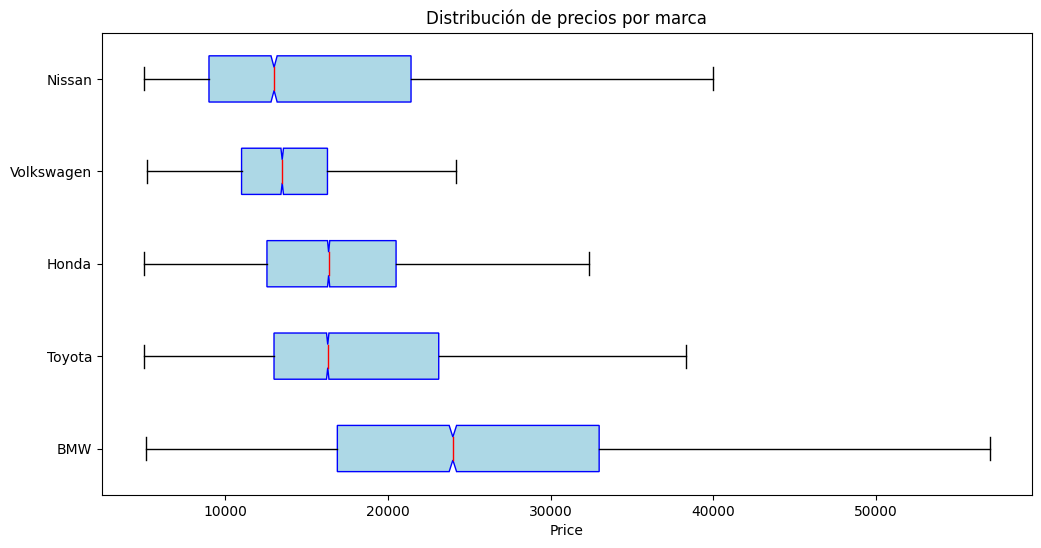

In [9]:

plt.figure(figsize=(12,6))
plt.boxplot([dataTraining.loc[dataTraining['Make']=='BMW', 'Price'],
             dataTraining.loc[dataTraining['Make']=='Toyota', 'Price'],
             dataTraining.loc[dataTraining['Make']=='Honda', 'Price'],
             dataTraining.loc[dataTraining['Make']=='Volkswagen', 'Price'],
             dataTraining.loc[dataTraining['Make']=='Nissan', 'Price']], 
            labels=['BMW', 'Toyota', 'Honda', 'Volkswagen', 'Nissan'],
            showfliers=False,
            notch=True,
            vert=False,
            patch_artist=True,
            boxprops=dict(facecolor='lightblue', color='blue'),
            whiskerprops=dict(color='black'),
            medianprops=dict(color='red'))

plt.xlabel('Price')
plt.title('Distribución de precios por marca')
plt.show()

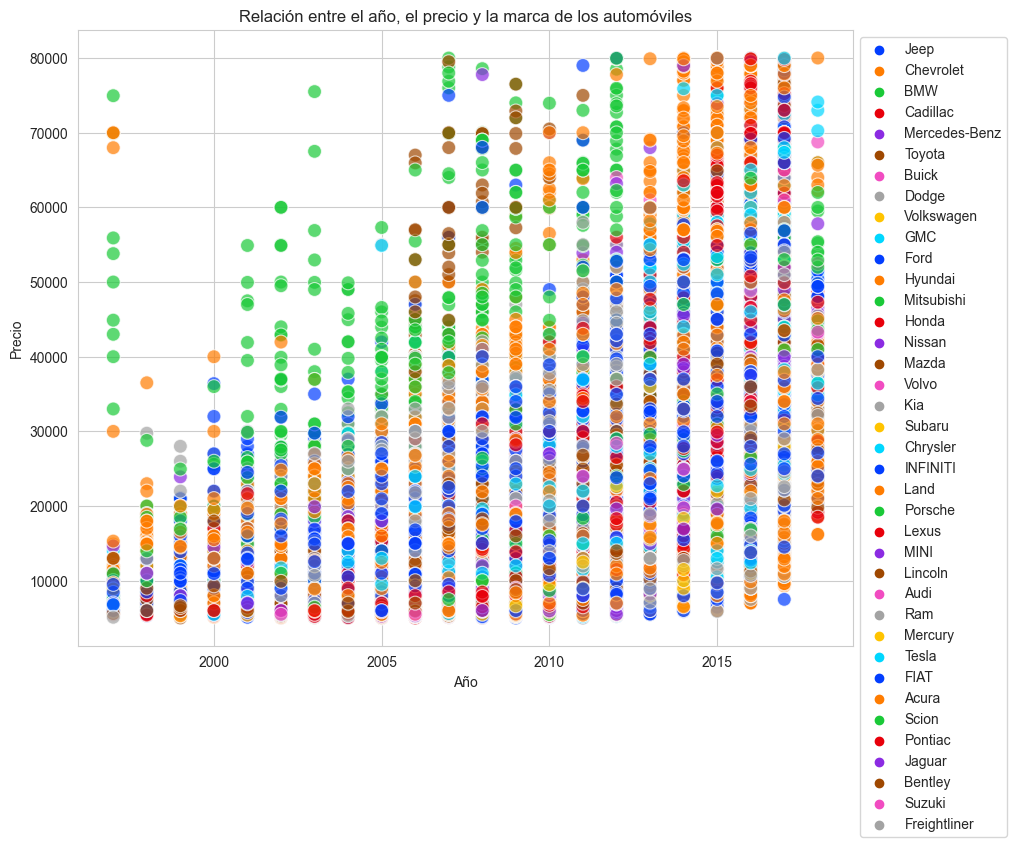

In [10]:
sns.set_style('whitegrid')

plt.figure(figsize=(10,8))
sns.scatterplot(x='Year', y='Price', hue='Make', data=dataTraining, s=100, alpha=0.7, palette='bright')
plt.xlabel('Año')
plt.ylabel('Precio')
plt.title('Relación entre el año, el precio y la marca de los automóviles')
plt.legend(bbox_to_anchor=(1, 1), loc='upper left')
plt.show()

In [11]:
mean_prices = dataTraining.groupby('Make')['Price'].mean().reset_index()
mean_prices = mean_prices.sort_values('Price', ascending=False)
mean_prices

,Make,Price
3,Bentley,57256.333333
34,Tesla,55649.148649
19,Land,36191.879101
29,Porsche,34278.585714
30,Ram,31500.057602
24,Mercedes-Benz,30022.009241
12,GMC,28553.981137
11,Freightliner,26209.142857
20,Lexus,25903.224532
5,Cadillac,25467.825083


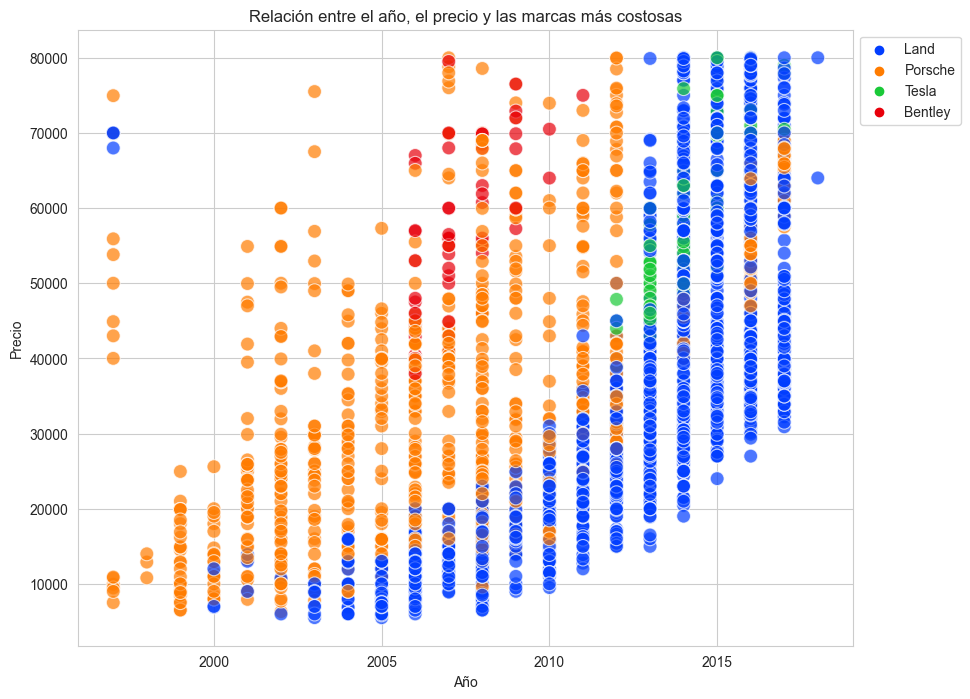

In [12]:
# Seleccionar las marcas más costosas
top_brands = ['Tesla', 'Bentley', 'Land', 'Porsche']

# Crear un nuevo DataFrame con las observaciones correspondientes a las marcas seleccionadas
df_top_brands = dataTraining[dataTraining['Make'].isin(top_brands)]

# Crear el gráfico de dispersión
plt.figure(figsize=(10,8))
sns.scatterplot(x='Year', y='Price', hue='Make', data=df_top_brands, s=100, alpha=0.7, palette='bright')
plt.xlabel('Año')
plt.ylabel('Precio')
plt.title('Relación entre el año, el precio y las marcas más costosas')
plt.legend(bbox_to_anchor=(1, 1), loc='upper left')
plt.show()

In [13]:
dataTraining.columns

Index(['Price', 'Year', 'Mileage', 'State', 'Make', 'Model'], dtype='object')

In [14]:
dataTraining.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400000 entries, 0 to 399999
Data columns (total 6 columns):
 #   Column   Non-Null Count   Dtype 
---  ------   --------------   ----- 
 0   Price    400000 non-null  int64 
 1   Year     400000 non-null  int64 
 2   Mileage  400000 non-null  int64 
 3   State    400000 non-null  object
 4   Make     400000 non-null  object
 5   Model    400000 non-null  object
dtypes: int64(3), object(3)
memory usage: 18.3+ MB


In [15]:
#Resumen estadístico de las variables numéricas
dataTraining.describe()

,Price,Year,Mileage
count,400000.000000,400000.000000,4.000000e+05
mean,21146.919312,2013.198125,5.507296e+04
std,10753.664940,3.292326,4.088102e+04
min,5001.000000,1997.000000,5.000000e+00
25%,13499.000000,2012.000000,2.584100e+04
50%,18450.000000,2014.000000,4.295500e+04
75%,26999.000000,2016.000000,7.743300e+04
max,79999.000000,2018.000000,2.457832e+06


In [16]:
#Conteo de valores únicos para cada variable categórica
dataTraining.select_dtypes(include=['object']).nunique()

State     51
Make      38
Model    525
dtype: int64

<AxesSubplot:xlabel='Price', ylabel='Count'>

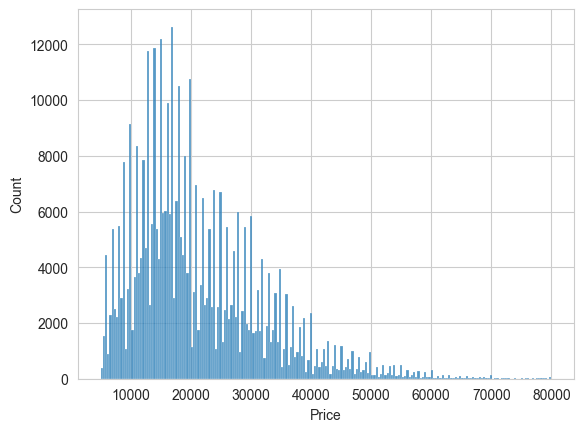

In [17]:
#Distribución del precio de los automóviles
sns.histplot(dataTraining.Price)

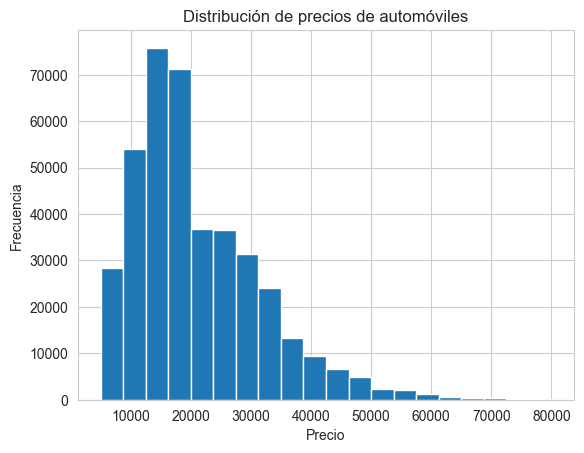

In [18]:
# Histograma de precios
plt.hist(dataTraining['Price'], bins=20)
plt.xlabel('Precio')
plt.ylabel('Frecuencia')
plt.title('Distribución de precios de automóviles')
plt.show()

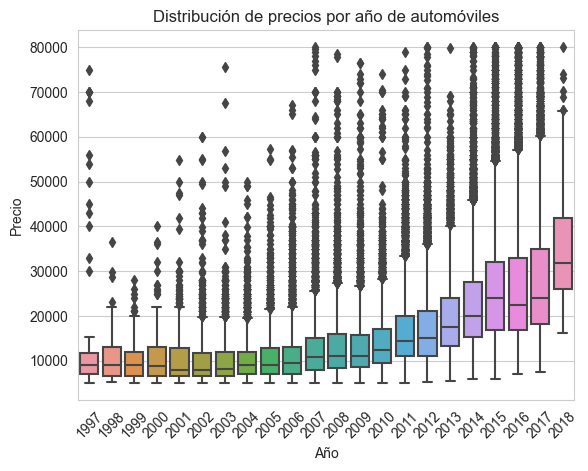

In [19]:
#Distribución de precios de los automóviles según el Año

sns.boxplot(x='Year', y='Price', data=dataTraining)
plt.xlabel('Año')
plt.ylabel('Precio')
plt.title('Distribución de precios por año de automóviles')
plt.xticks(rotation=45) # Rotar las etiquetas del eje X en 45 grados
plt.show()

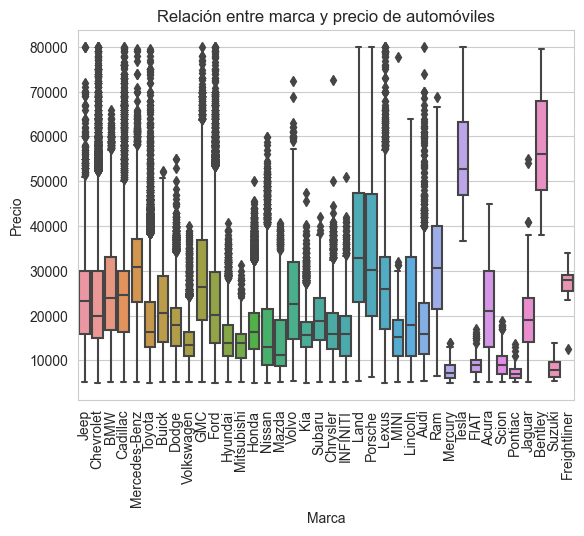

In [20]:
# Diagrama de dispersión de precio vs marca
sns.boxplot(x='Make', y='Price', data=dataTraining)
plt.xlabel('Marca')
plt.ylabel('Precio')
plt.title('Relación entre marca y precio de automóviles')
plt.xticks(rotation=90)
plt.show()

<AxesSubplot:>

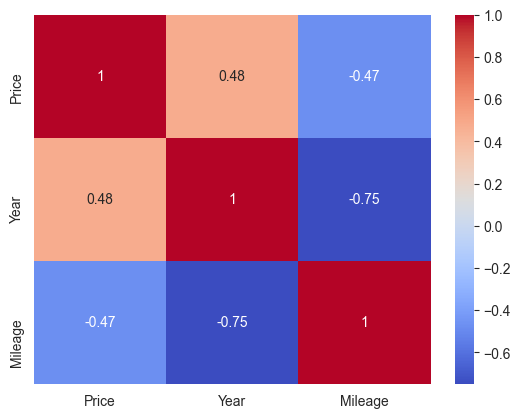

In [21]:
#Matriz de correlación
corr_matrix = dataTraining.corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')

<AxesSubplot:xlabel='Price', ylabel='Mileage'>

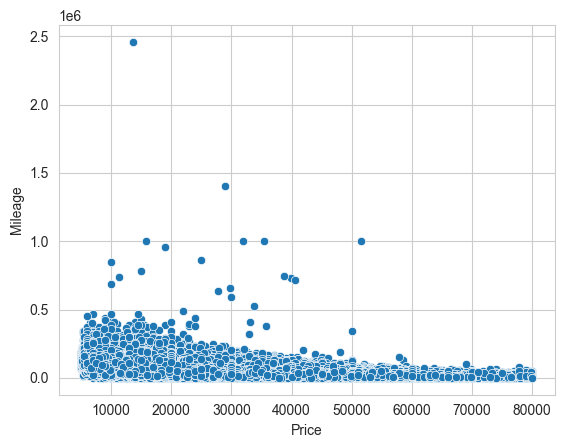

In [22]:
#Gráfico de dispersión para visualizar la relación entre las variables 'km' y 'precio'
sns.scatterplot(x='Price', y='Mileage', data=dataTraining)

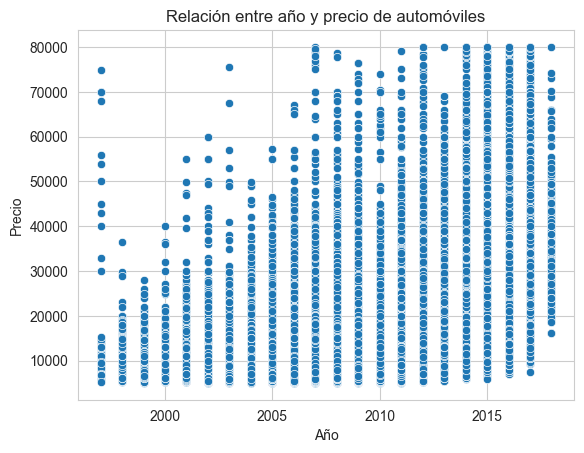

In [23]:
# Diagrama de dispersión de precio vs año
sns.scatterplot(x='Year', y='Price', data=dataTraining)
plt.xlabel('Año')
plt.ylabel('Precio')
plt.title('Relación entre año y precio de automóviles')
plt.show()


Algunas conclusiones que se pueden obtener a partir de estas visualizaciones son:


Las marcas de automóviles con precios más altos son BMW, Audi y Mercedes-Benz.

El precio de los automóviles tiene una correlación positiva con el año y una correlación negativa con el kilometraje.

Hay una gran variación en los precios de los automóviles en cada año, con algunos automóviles teniendo precios mucho más altos que otros; Esto puede deberse a una serie de factores, como la marca, el modelo, la condición del automóvil y la demanda del mercado.

La mayoría de los automóviles tienen un precio de alrededor de $20,000 o menos. 

La mayoría de los automóviles en el conjunto de datos tienen precios inferiores a los $50,000.

Hay algunos valores atípicos en la parte superior de la distribución, con algunos automóviles que tienen precios de más de $100,000.

La marca del automóvil tiene un impacto significativo en el precio. Las marcas de automóviles de lujo tienden a tener precios más altos en comparación con las marcas de automóviles más populares.

Las variables del modelo y la ciudad no parecen tener una correlación significativa con el precio.

In [24]:
# Seleccionar las variables predictoras y la variable objetivo
dataTraining.head()



,Price,Year,Mileage,State,Make,Model
0,34995,2017,9913,FL,Jeep,Wrangler
1,37895,2015,20578,OH,Chevrolet,Tahoe4WD
2,18430,2012,83716,TX,BMW,X5AWD
3,24681,2014,28729,OH,Cadillac,SRXLuxury
4,26998,2013,64032,CO,Jeep,Wrangler


## PRIMER MODELO - Randon Forest

In [25]:
# Importar la librería category_encoders


# Crear una copia del conjunto de datos original
X = dataTraining.copy()

# Extraer las variables independientes y la variable dependiente
y = X['Price']
X = X.drop(['Price'], axis=1)

X.columns



Index(['Year', 'Mileage', 'State', 'Make', 'Model'], dtype='object')

In [26]:
# Codificar las variables categóricas con la codificación de frecuencia
encoder = ce.CountEncoder(cols=['State', 'Make', 'Model'])
X = encoder.fit_transform(X)
X.columns

Index(['Year', 'Mileage', 'State', 'Make', 'Model'], dtype='object')

## Category_encoders


Cuando hay muchas categorías en una variable categórica, la creación de variables dummy puede resultar en un gran aumento en el número de columnas del conjunto de datos, lo que puede hacer que el modelo sea más complejo y difícil de entrenar. Una forma de abordar este problema es mediante el uso de técnicas de reducción de dimensionalidad como la codificación de frecuencia.

La codificación de frecuencia asigna a cada categoría de una variable categórica un valor numérico basado en su frecuencia de aparición en el conjunto de datos. Las categorías más frecuentes reciben valores más altos, mientras que las menos frecuentes reciben valores más bajos. Esto permite reducir el número de columnas en el conjunto de datos y, al mismo tiempo, mantener la información sobre las categorías.

In [27]:
X.head()

,Year,Mileage,State,Make,Model
0,2017,9913,33759,24369,5914
1,2015,20578,11364,58383,1912
2,2012,83716,45918,12326,601
3,2014,28729,11364,5414,1270
4,2013,64032,10875,24369,5914


In [28]:


# Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


# Crear el modelo de Random Forest
model_rf = RandomForestRegressor(n_estimators=100, random_state=42)

# Entrenar el modelo
model_rf.fit(X_train, y_train)

# Predecir los precios en el conjunto de prueba
y_pred = model_rf.predict(X_test)


In [29]:

# Calcular el error 
mae = mean_absolute_error(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred, squared=False)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
y_pred = model_rf.predict(X_test)
mape_score = mean_absolute_percentage_error(y_test, y_pred)

print("MAPE:", mape_score)
print('Error absoluto medio:', mae)
print('R-cuadrado:', r2)

MAPE: 0.12034032228030976
Error absoluto medio: 2415.105597909449
R-cuadrado: 0.8699663431389296


Estos valores indican lo siguiente:

Un MAPE de 0.12 significa que en promedio, las predicciones del modelo se desvían en un 12% del valor real. Esto sugiere que el modelo tiene una buena precisión en la predicción del precio de los automóviles en el conjunto de prueba.

El error absoluto medio de 2416.77 indica que, en promedio, las predicciones del modelo se desvían de los valores reales en 2416.77 unidades de la variable objetivo.

El R-cuadrado de 0.8695 indica que el modelo explica aproximadamente el 87% de la variabilidad en los datos. Este valor es relativamente alto, lo que sugiere que el modelo tiene un buen ajuste a los datos y es capaz de hacer predicciones precisas.

En general, estos valores indican que el modelo de Random Forest que entrenaste es capaz de hacer predicciones precisas sobre el precio de los automóviles en función de las variables predictoras incluidas en el conjunto de datos.

# Definir los hiperparámetros a calibrar
from sklearn.model_selection import GridSearchCV

param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [5, 10, 20, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['auto', 'sqrt', 'log2']
}

# Realizar una búsqueda en la grilla de hiperparámetros
grid_search = GridSearchCV(estimator=model_rf, param_grid=param_grid, cv=5, n_jobs=-1, scoring='neg_mean_absolute_error')
grid_search.fit(X_train, y_train)

# Imprimir los mejores hiperparámetros y el MAE asociado
print('Mejores hiperparámetros:', grid_search.best_params_)
print('MAE asociado:', -grid_search.best_score_)

In [ ]:


# Definir función de objetivo
def objective(trial):
    # Definir espacio de búsqueda para los hiperparámetros
    n_estimators = trial.suggest_int('n_estimators', 100, 1000)
    max_depth = trial.suggest_int('max_depth', 2, 32, log=True)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 10)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 10)
    
    # Crear modelo de Random Forest con los hiperparámetros sugeridos
    model = RandomForestRegressor(n_estimators=n_estimators,
                                   max_depth=max_depth,
                                   min_samples_split=min_samples_split,
                                   min_samples_leaf=min_samples_leaf)
    
    # Calcular puntuación de validación cruzada utilizando MAE
    score = -1.0 * cross_val_score(model, X_train, y_train, cv=5, scoring='neg_mean_absolute_error').mean()
    return score

# Dividir datos en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
# Crear objeto de estudio Optuna
study = optuna.create_study(direction='minimize')
# Ejecutar optimización
study.optimize(objective, n_trials=100)

# Imprimir mejores hiperparámetros y puntuación
print('Mejores hiperparámetros:', study.best_params)
print('Mejor puntuación:', -1.0 * study.best_value)

[I 2023-04-21 20:40:45,046] A new study created in memory with name: no-name-7706204f-3650-409a-b99e-823eea743847


In [ ]:
y_pred_test = rf_random.predict(X_test)

print("Error absoluto medio:", mean_absolute_error(y_test, y_pred_test))
print("Error cuadrático medio:", mean_squared_error(y_test, y_pred_test))
print("Error cuadrático medio de la raíz:", np.sqrt(mean_squared_error(y_test, y_pred_test)))
print("R-cuadrado:", r2_score(y_test, y_pred_test))
print("MAPE:", mean_absolute_percentage_error(y_test, y_pred_test))